# QKeras dense layer comparison


## Imports

In [2]:
import tensorflow as tf
import keras
import numpy as np
import time
import random

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque


from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import plotting


2022-04-21 12:52:32.139902: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21.1.0.169.pro/hls/host/linux64/lib
2022-04-21 12:52:32.139919: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


## Data creation 

In [6]:
#Creating a simple dataset using numpy

x = np.linspace(-1, 1, 1000)
y = np.sin(5*x)

x_val = np.linspace(-1, 1, 100)
y_val = np.sin(5*x_val)

x_test = np.linspace(-1, 1, 1000)
y_test = np.sin(5*x_test)



In [3]:
with open("inputs.txt", "w") as inputs_file :
    for i in range(1000):
        save_inputs = str(float(y[i]))
        inputs_file.write("{}\n".format(save_inputs))

In [3]:
import os
print(os.environ['LD_LIBRARY_PATH'])
print('and\n', os.environ['PATH'])

/cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21.1.0.169.pro/hls/host/linux64/lib
and
 /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/quartus/bin:/inteltools/altera/21.1.0.169.pro/gcc/bin:/inteltools/altera/21.1.0.169.pro/hls/bin:/inteltools/altera/21.1.0.169.pro/qsys/bin:/inteltools/altera/21.1.0.169.pro/quartus/bin:/inteltools/mentor/2018-19/RHELx86/QUESTA-CORE-PRIME_10.7c/questasim/linux_x86_64:/atlas/bonnet/miniconda3/envs/hls4ml-tutorial/bin:/atlas/bonnet/miniconda3/condabin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin


## Settings

In [32]:
output = 1

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+3)*2

integer = (4)

def bit_width(i): return {'bits': (i+3)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

nbr_epoch = 15

## Classic network

In [7]:
checkpoint_filepath = '/atlas/bonnet/tmp/model_checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)

d_model = Sequential()

d_model.add(Dense(10,input_dim= 1,activation='relu', name='dense'))
d_model.add(Dense(output, activation='linear', name='dense_1'))
d_model.compile(loss="mse", optimizer=Adam(lr=0.001))

d_model.summary()

d_model.fit(x, y, validation_data= (x_val,y_val), epochs=80, batch_size=10, callbacks=[reduce_lr,model_checkpoint_callback])

#d_model.load_weights(checkpoint_filepath)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
100/100 [==============================] - 0s 2ms/step - loss: 0.5069 - val_loss: 0.4877 - lr: 0.0010
Epoch 2/80
100/100 [==============================] - 0s 806us/step - loss: 0.4689 - val_loss: 0.4529 - lr: 0.0010
Epoch 3/80
100/100 [==============================] - 0s 781us/step - loss: 0.4375 - val_loss: 0.4226 - lr: 0.0010
Epoch 4/80
100/100 [==============================] - 0s 789us/step - loss: 0.4102 - val_loss: 0.3959 - lr: 0.0

## Quantized network : 

In [39]:
def quantized_model (bits,bits_lenghts, original_weights):
    qcheckpoint_filepath = '/atlas/bonnet/tmp/qmodel_checkpoint'
    qmodel_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=qcheckpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)


    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)

    qd_model = Sequential()
    
    qd_model.add(QDense(10,
                        input_dim= 1,
                        activation='relu',   
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))
    #qd_model.add(QActivation(activation=quantized_relu(bits=bits['bits'], integer = bits['integer']), name='relu1'))                   
    qd_model.add(QDense(output, 
                        activation='linear',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))
    #qd_model.add(QActivation(activation=quantized_bits(**bits), name='linear1'))
    qd_model.compile(loss="mse", optimizer=Adam(lr=0.0001))
    
    qd_model.summary()
    
    #using the weight from the classic network as a base
    qd_model.set_weights(original_weights.get_weights())
    qd_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_epoch, callbacks=[qmodel_checkpoint_callback,reduce_lr])
    qd_model.load_weights(qcheckpoint_filepath)

    return qd_model

def model_saving (): 
    models =[]
    for i in range(9):
        bits_parameter = bit_width(i)
        bits_lenghts = bit_lenghts(i)
        models.append( quantized_model(bits_parameter, bits_lenghts, d_model))
        print( 'bit width ', bits_parameter)        
    return models
        
qmodels = model_saving()
        


Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense_72 (QDense)         (None, 10)                20        
                                                                 
 q_dense_73 (QDense)         (None, 1)                 11        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15


/atlas/bonnet/miniconda3/envs/hls4ml-tutorial/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


32/32 [==============================] - 1s 6ms/step - loss: 0.8587 - val_loss: 0.8750 - lr: 1.0000e-04
Epoch 2/15
32/32 [==============================] - 0s 2ms/step - loss: 0.2130 - val_loss: 0.1385 - lr: 1.0000e-04
Epoch 3/15
32/32 [==============================] - 0s 1ms/step - loss: 0.1333 - val_loss: 0.1385 - lr: 1.0000e-04
Epoch 4/15
32/32 [==============================] - 0s 1ms/step - loss: 0.1333 - val_loss: 0.1385 - lr: 1.0000e-04
Epoch 5/15
32/32 [==============================] - 0s 1ms/step - loss: 0.1333 - val_loss: 0.1385 - lr: 1.0000e-04
Epoch 6/15
32/32 [==============================] - 0s 993us/step - loss: 0.1333 - val_loss: 0.1385 - lr: 1.0000e-04
Epoch 7/15
 1/32 [..............................] - ETA: 0s - loss: 0.1230
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
32/32 [==============================] - 0s 949us/step - loss: 0.1333 - val_loss: 0.1385 - lr: 1.0000e-04
Epoch 8/15
32/32 [==============================] - 0s 932us/s

In [20]:
    

quantized_bits(**bit_width(8))

In [12]:
for i  in range (9):    
    print(quantized_bits(**bit_width(i)))

quantized_bits(6,4,0,alpha=1)
quantized_bits(8,4,0,alpha=1)
quantized_bits(10,4,0,alpha=1)
quantized_bits(12,4,0,alpha=1)
quantized_bits(14,4,0,alpha=1)
quantized_bits(16,4,0,alpha=1)
quantized_bits(18,4,0,alpha=1)
quantized_bits(20,4,0,alpha=1)
quantized_bits(22,4,0,alpha=1)


## Normal network, Quantized weights

In [29]:
configu = d_model.get_config()
tmp_model = Sequential().from_config(configu)
tmp_models = []

print(configu)   

for i in range (9) :   
    tmp_model.set_weights([quantized_bits(**bit_width(i))(n) for n in qmodels[i].get_weights()])
    tmp_models.append(tmp_model)


{'name': 'sequential_1', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_input'}}, {'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 1), 'dtype': 'float32', 'units': 10, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regulari

## HLS4ML CONVERSION PART

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

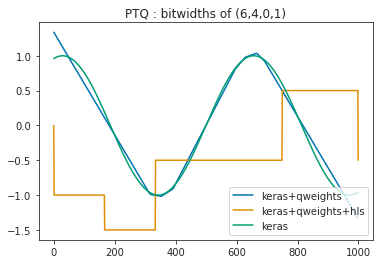

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

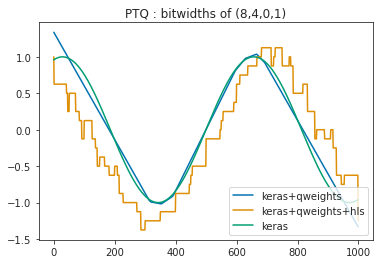

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

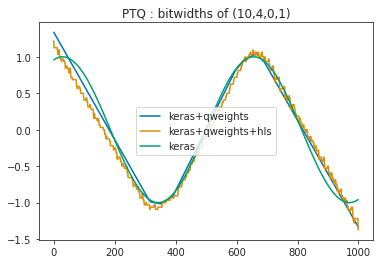

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

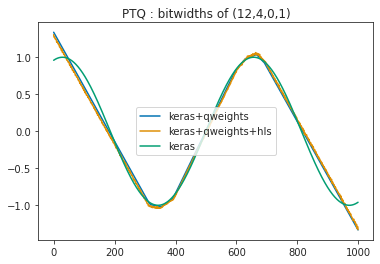

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

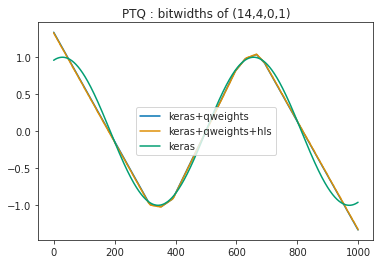

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

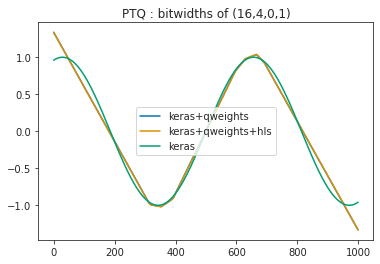

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

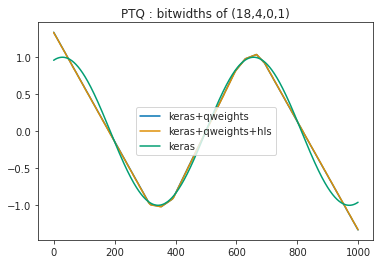

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

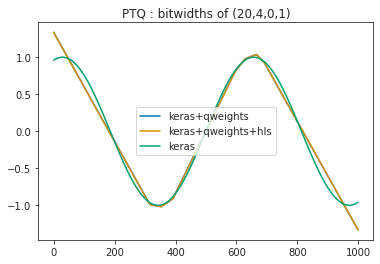

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

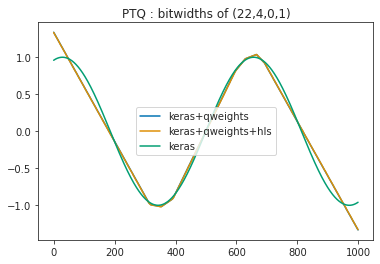

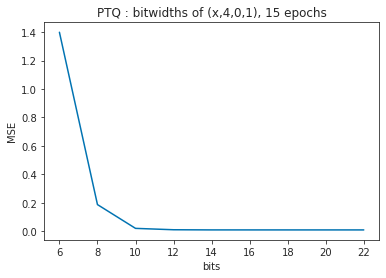

In [59]:


closs = []
qcloss = []
qchloss = []
ptq_results = []

bit_scale = []
for i in range (9):
    conf = hls4ml.utils.config_from_keras_model( d_model, granularity='name')
    print(conf)
    conf['LayerName']['dense']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},5>'
    conf['LayerName']['dense']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},5>'
    conf['LayerName']['dense']['Precision']['result'] = f'ap_fixed<{bit_lenghts(i)},5>'

    conf['LayerName']['dense_relu']['Precision'] = f'ap_fixed<{bit_lenghts(i)},5>'
    conf['LayerName']['dense_relu']['table_t'] = f'ap_fixed<{bit_lenghts(i)},5>'

    conf['LayerName']['dense_1']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},5>'
    conf['LayerName']['dense_1']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},5>'
    conf['LayerName']['dense_1']['Precision']['result'] = f'ap_fixed<{bit_lenghts(i)},5>'
    
    conf['LayerName']['dense_1_linear']['Precision'] = f'ap_fixed<{bit_lenghts(i)},5>'
    conf['LayerName']['dense_1_linear']['table_t'] = f'ap_fixed<{bit_lenghts(i)},5>'
    print(conf)
        
    hls_model = hls4ml.converters.convert_from_keras_model(d_model,
                                                            hls_config=conf,
                                                            output_dir='models/hls_models',
                                                            part='1SG280HU2F50E2VG',
                                                            backend='Quartus')
    hls_model.compile()

    y_qckeras = tmp_models[i].predict(x_test)
    y_qchls = hls_model.predict(x_test.reshape(x_test.shape[0],1))
    ptq_results.append(y_qchls)
    y_keras = d_model.predict(x_test)
    print ('shape', np.shape(y_qckeras))
    closs.append(mse(y_test, y_keras))
    qcloss.append(mse(y_test, y_qckeras))
    qchloss.append(mse(y_test, y_qchls))
    bit_scale.append(bit_lenghts(i))
    plt.figure()
    plt.plot(y_qckeras)
    plt.plot(y_qchls)
    plt.plot(y_test)    
    plt.legend(['keras+qweights', 'keras+qweights+hls', 'keras'])
    plt.title(f'PTQ : bitwidths of ({bit_lenghts(i)},{integer},0,1)')
    plt.show()

plt.figure()
plt.plot(bit_scale, qchloss)
plt.xlabel('bits')
plt.ylabel('MSE')
plt.title(f'PTQ : bitwidths of (x,{integer},0,1), {nbr_epoch} epochs')

plt.show()

plt.show()

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

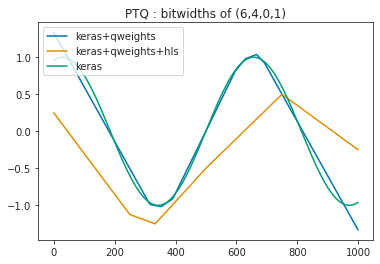

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

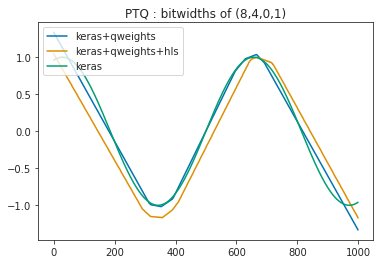

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

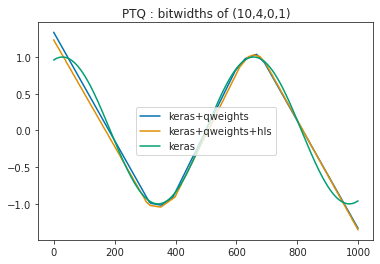

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

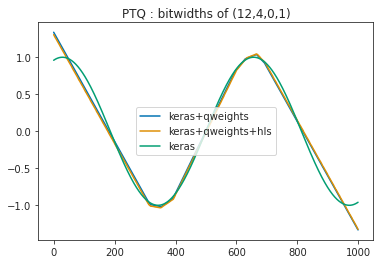

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

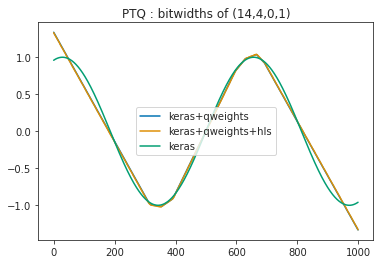

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

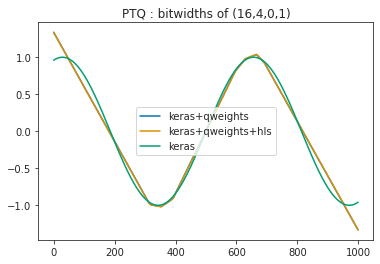

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

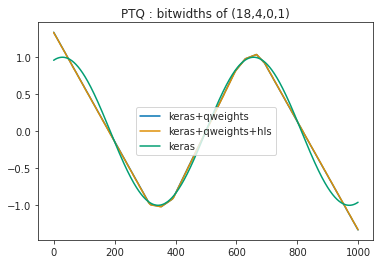

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

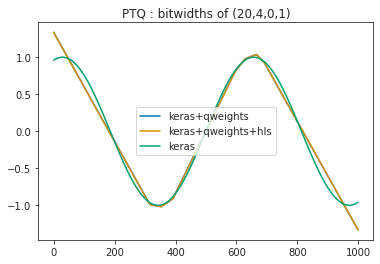

Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (linear), layer name: dense_1
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {

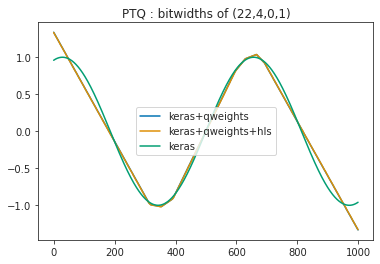

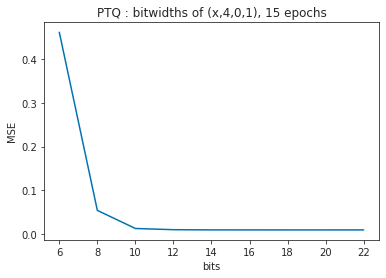

In [43]:
####### classic model using quantized weights


qcloss = []
qchloss = []
closs = []
ptq2 = []

bit_scale = []
for i in range (9):
    conf = hls4ml.utils.config_from_keras_model(d_model, granularity='name')
    print (conf)

    conf['LayerName']['dense']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},5>'
    conf['LayerName']['dense']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},5>'

    conf['LayerName']['dense_1']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},5>'
    conf['LayerName']['dense_1']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},5>'

    print(conf)

    hls_model = hls4ml.converters.convert_from_keras_model(d_model,
                                                        hls_config=conf,
                                                        output_dir='models/hls_models',
                                                        part='1SG280HU2F50E2VG',
                                                        backend='Quartus')
    hls_model.compile()

    y_qckeras = tmp_models[i].predict(x_test)
    y_qchls = hls_model.predict(x_test.reshape(x_test.shape[0],1))
    ptq2.append(y_qchls)
    y_keras = d_model.predict(x_test)
    print ('shape', np.shape(y_qckeras))
    closs.append(mse(y_test, y_keras))
    qcloss.append(mse(y_test, y_qckeras))
    qchloss.append(mse(y_test, y_qchls))
    bit_scale.append(bit_lenghts(i))
    plt.figure()
    #plt.subplot()
    #plt.plot(y_keras)
    plt.plot(y_qckeras)
    plt.plot(y_qchls)
    plt.plot(y_test)    
    plt.legend(['keras+qweights', 'keras+qweights+hls', 'keras'])
    plt.title(f'PTQ : bitwidths of ({bit_lenghts(i)},{integer},0,1)')
    plt.show()


plt.figure()
plt.plot(bit_scale, qchloss)
plt.xlabel('bits')
plt.ylabel('MSE')
plt.title(f'PTQ : bitwidths of (x,{integer},0,1), {nbr_epoch} epochs')

plt.show()




## quantized model

In [9]:
"""
def write (model):
    
    fout = open(f'model{i}'.format(model.config.get_output_dir(), model.config.get_project_name()),'w')"""

"\ndef write (model):\n    \n    fout = open(f'model{i}'.format(model.config.get_output_dir(), model.config.get_project_name()),'w')"

In [10]:
for i, w in enumerate(qmodels) :
    qmodel_json = qmodels[i].to_json()
    with open(f"qmodels/models/qmodel{i}.json", "w") as json_file:
        json_file.write(qmodel_json)
    tmp_model.save_weights(f"qmodels/weights/qmodel{i}.h5")
    print("Saved model to disk")

Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk


Interpreting Sequential
Topology:
Layer name: q_dense_72_input, layer type: Input
Layer name: q_dense_72, layer type: QDense
Layer name: q_dense_73, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_72_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_72': {'Precision': {'weight': 'ap_fixed<6,5>', 'bias': 'ap_fixed<6,5>'}, 'ReuseFactor': 1}, 'q_dense_73': {'Precision': {'weight': 'ap_fixed<6,5>', 'bias': 'ap_fixed<6,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_72_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_72, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_73, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 1]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 433us/step


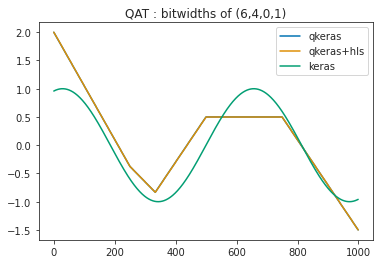

Interpreting Sequential
Topology:
Layer name: q_dense_74_input, layer type: Input
Layer name: q_dense_74, layer type: QDense
Layer name: q_dense_75, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_74_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_74': {'Precision': {'weight': 'ap_fixed<8,5>', 'bias': 'ap_fixed<8,5>'}, 'ReuseFactor': 1}, 'q_dense_75': {'Precision': {'weight': 'ap_fixed<8,5>', 'bias': 'ap_fixed<8,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_74_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_74, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_75, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 1]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 470us/step


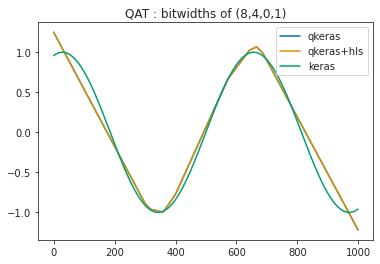

Interpreting Sequential
Topology:
Layer name: q_dense_76_input, layer type: Input
Layer name: q_dense_76, layer type: QDense
Layer name: q_dense_77, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_76_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_76': {'Precision': {'weight': 'ap_fixed<10,5>', 'bias': 'ap_fixed<10,5>'}, 'ReuseFactor': 1}, 'q_dense_77': {'Precision': {'weight': 'ap_fixed<10,5>', 'bias': 'ap_fixed<10,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_76_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_76, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_77, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 1]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 419us/step


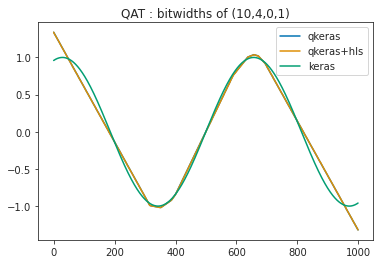

Interpreting Sequential
Topology:
Layer name: q_dense_78_input, layer type: Input
Layer name: q_dense_78, layer type: QDense
Layer name: q_dense_79, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_78_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_78': {'Precision': {'weight': 'ap_fixed<12,5>', 'bias': 'ap_fixed<12,5>'}, 'ReuseFactor': 1}, 'q_dense_79': {'Precision': {'weight': 'ap_fixed<12,5>', 'bias': 'ap_fixed<12,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_78_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_78, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_79, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 1]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 453us/step


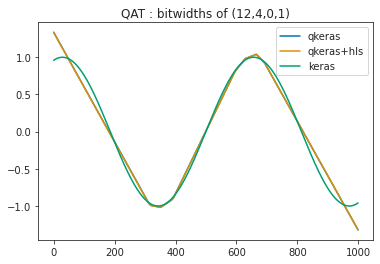

Interpreting Sequential
Topology:
Layer name: q_dense_80_input, layer type: Input
Layer name: q_dense_80, layer type: QDense
Layer name: q_dense_81, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_80_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_80': {'Precision': {'weight': 'ap_fixed<14,5>', 'bias': 'ap_fixed<14,5>'}, 'ReuseFactor': 1}, 'q_dense_81': {'Precision': {'weight': 'ap_fixed<14,5>', 'bias': 'ap_fixed<14,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_80_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_80, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_81, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 1]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 440us/step


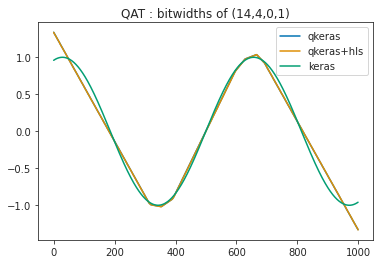

Interpreting Sequential
Topology:
Layer name: q_dense_82_input, layer type: Input
Layer name: q_dense_82, layer type: QDense
Layer name: q_dense_83, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_82_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_82': {'Precision': {'weight': 'ap_fixed<16,5>', 'bias': 'ap_fixed<16,5>'}, 'ReuseFactor': 1}, 'q_dense_83': {'Precision': {'weight': 'ap_fixed<16,5>', 'bias': 'ap_fixed<16,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_82_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_82, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_83, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 1]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 431us/step


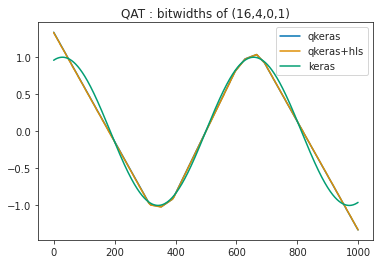

Interpreting Sequential
Topology:
Layer name: q_dense_84_input, layer type: Input
Layer name: q_dense_84, layer type: QDense
Layer name: q_dense_85, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_84_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_84': {'Precision': {'weight': 'ap_fixed<18,5>', 'bias': 'ap_fixed<18,5>'}, 'ReuseFactor': 1}, 'q_dense_85': {'Precision': {'weight': 'ap_fixed<18,5>', 'bias': 'ap_fixed<18,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_84_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_84, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_85, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 1]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 458us/step


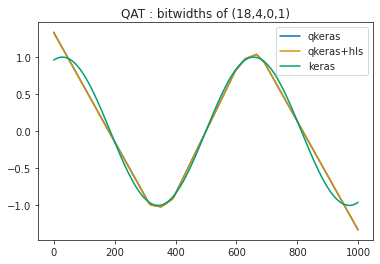

Interpreting Sequential
Topology:
Layer name: q_dense_86_input, layer type: Input
Layer name: q_dense_86, layer type: QDense
Layer name: q_dense_87, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_86_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_86': {'Precision': {'weight': 'ap_fixed<20,5>', 'bias': 'ap_fixed<20,5>'}, 'ReuseFactor': 1}, 'q_dense_87': {'Precision': {'weight': 'ap_fixed<20,5>', 'bias': 'ap_fixed<20,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_86_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_86, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_87, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 1]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 531us/step


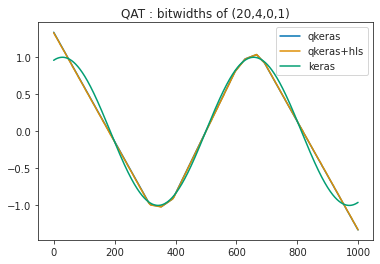

Interpreting Sequential
Topology:
Layer name: q_dense_88_input, layer type: Input
Layer name: q_dense_88, layer type: QDense
Layer name: q_dense_89, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_88_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_88': {'Precision': {'weight': 'ap_fixed<22,5>', 'bias': 'ap_fixed<22,5>'}, 'ReuseFactor': 1}, 'q_dense_89': {'Precision': {'weight': 'ap_fixed<22,5>', 'bias': 'ap_fixed<22,5>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_88_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_88, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_89, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 1]
Creating HLS model
Writing HLS project
Done
32/32 [==============================] - 0s 508us/step


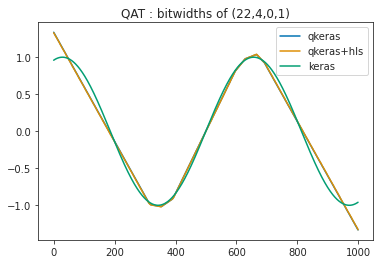

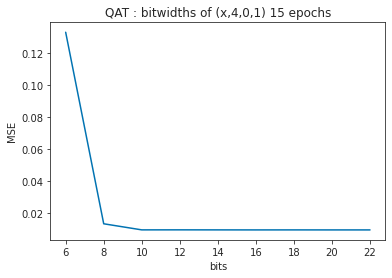

In [56]:
####### quantized model 

qhloss = []
qloss = []
bit_scale = []
qat_results = []
for i in range (9):
    conf = hls4ml.utils.config_from_keras_model(qmodels[i], granularity='name')
    print(conf)

    hls_qmodel = hls4ml.converters.convert_from_keras_model(qmodels[i],
                                                        hls_config=conf,
                                                        output_dir='models/hls_models',
                                                        part='1SG280HU2F50E2VG',
                                                        backend='Quartus')
                                
    #fout = open(f'qmodel{i}.yml'.format(hls_qmodel.config.get_output_dir(), hls_qmodel.config.get_project_name()),'w')

    hls_qmodel.compile()

    y_qkeras = qmodels[i].predict(x_test)
    y_qhls = hls_qmodel.predict(x_test.reshape(x_test.shape[0],1))
    qat_results.append(y_qhls)
    y_keras = d_model.predict(x_test)
    qhloss.append(mse(y_test, y_qhls))
    qloss.append(mse(y_test, y_qkeras))
    bit_scale.append(bit_lenghts(i))
    plt.figure()
    #plt.subplot()
    #plt.plot(y_keras)
    plt.plot(y_qkeras)
    plt.plot(y_qhls)
    plt.plot(y_test)    
    plt.legend(['qkeras', 'qkeras+hls', 'keras'])
    plt.title(f'QAT : bitwidths of ({bit_lenghts(i)},{integer},0,1)')
    plt.show()


plt.figure()
plt.plot(bit_scale, qhloss)
plt.xlabel('bits')
plt.ylabel('MSE')
plt.title(f'QAT : bitwidths of (x,{integer},0,1) {nbr_epoch} epochs')

plt.show()


In [15]:
with open("outputs_hls.txt", "w") as outputs_file :
    for i in range(1000):
        save_outputs = str(float(y_qhls[i]))
        outputs_file.write("{}\n".format(save_outputs))

print(y_qhls)

[[-1.09375   ]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09375   ]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09375   ]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09375   ]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09375   ]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09570312]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09570312]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09570312]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09570312]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09570312]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09375   ]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09375   ]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09375   ]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09375   ]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09375   ]
 [-1.09472656]
 [-1.09570312]
 [-1.09570312]
 [-1.09472656]
 [-1.09472656]
 [-1.09570312]
 [-1.09570

['0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '0.125', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '-0', '.25', '0.625

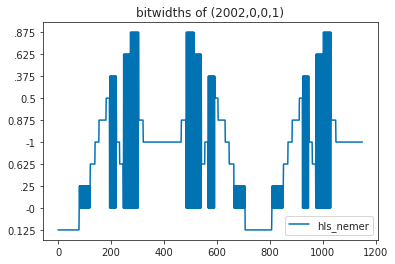

In [16]:
import re


with open('../test_nemer/results.log') as f:
    
    lines = re.findall('\d*?.\d+', f.read())
print(lines)

plt.figure()
plt.plot(lines)
#plt.plot(y_test)    
plt.legend(['hls_nemer', 'true'])
plt.title(f'bitwidths of ({bit_lenghts(i)},{integer},0,1)')
plt.show()


## Results

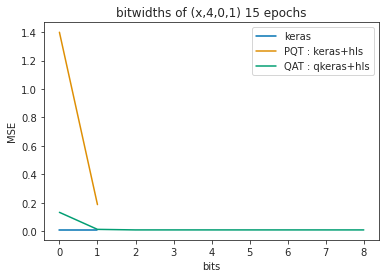

In [58]:
plt.figure()
plt.plot(closs)

plt.plot(qchloss)

plt.plot(qhloss)   
plt.legend(['keras','PQT : keras+hls',  'QAT : qkeras+hls'])

plt.xlabel('bits')
plt.ylabel('MSE')
plt.title(f'bitwidths of (x,{integer},0,1) {nbr_epoch} epochs')

plt.show()

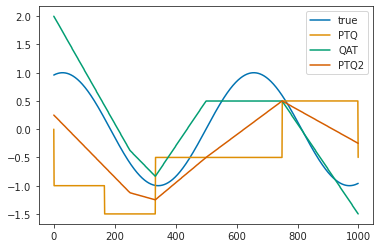

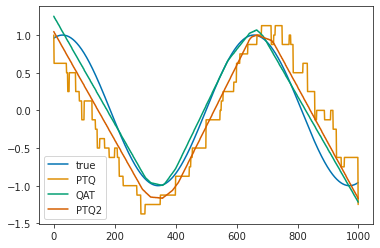

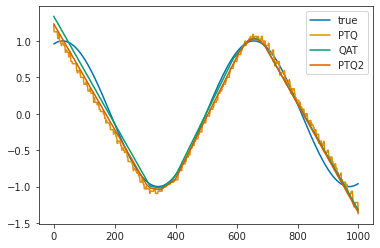

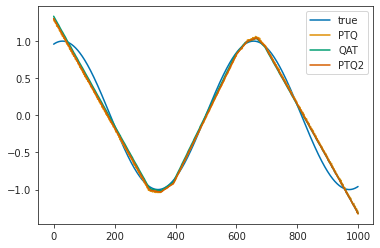

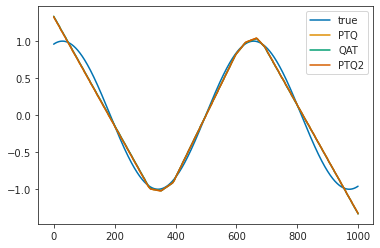

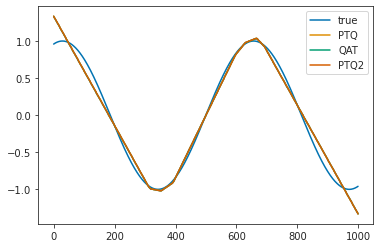

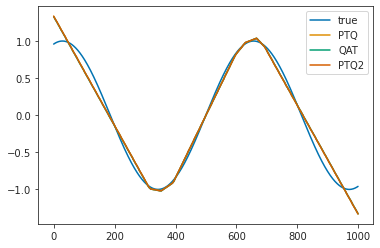

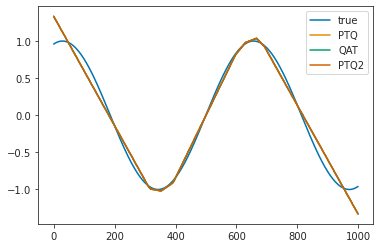

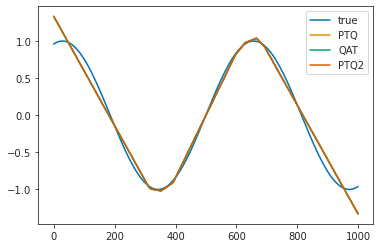

In [44]:
for q, p, p2 in zip (qat_results, ptq_results, ptq2):
    plt.plot(y)
    plt.plot(p)
    plt.plot(q)
    plt.plot(p2)

    plt.legend(['true','PTQ','QAT','PTQ2'])
    plt.show() 


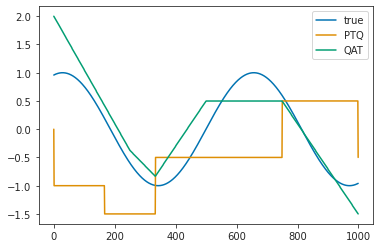

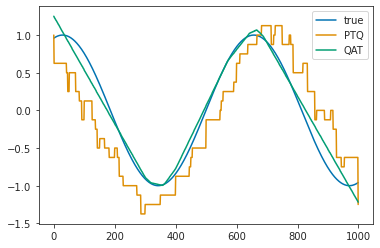

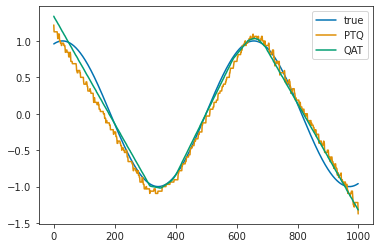

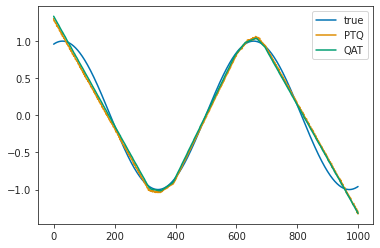

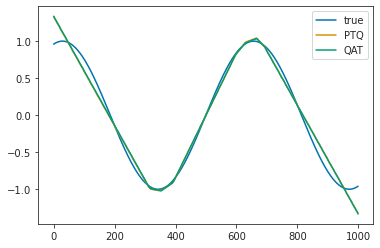

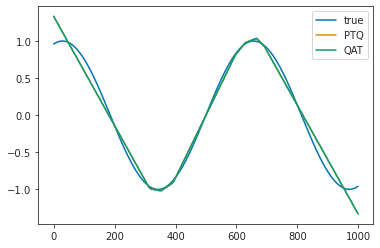

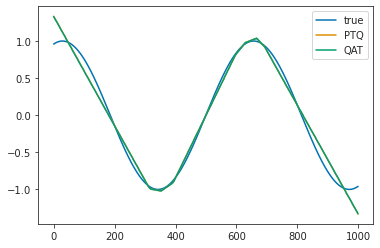

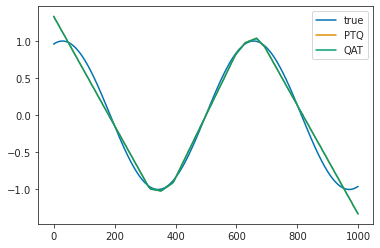

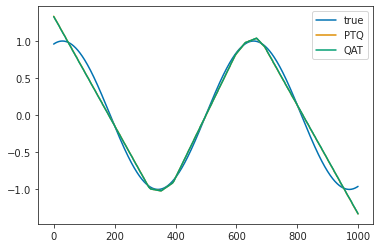

In [41]:
for q, p in zip (qat_results, ptq_results):
    plt.plot(y)
    plt.plot(p)
    plt.plot(q)
    plt.legend(['true','PTQ','QAT'])
    plt.show() 


(array([3., 5., 1., 4., 4., 3., 1., 8., 1., 1.]),
 array([-1.9321687 , -1.5278378 , -1.1235069 , -0.71917593, -0.31484503,
         0.08948588,  0.4938168 ,  0.8981477 ,  1.3024787 ,  1.7068095 ,
         2.1111405 ], dtype=float32),
 <BarContainer object of 10 artists>)

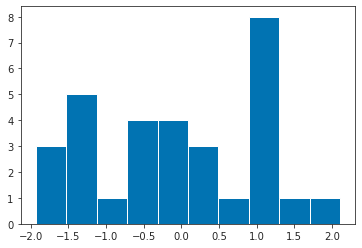

In [47]:
plt.hist(np.concatenate([i.flatten() for i in d_model.get_weights()]))



[array([[ 0.9893054 , -1.2706887 ,  0.855777  ,  0.90454954,  1.2510115 ,
        -1.1771712 , -1.4316438 ,  1.3824723 , -0.8355685 ,  1.1253464 ]],
      dtype=float32), array([-0.33512238, -0.46639037, -0.17167456, -0.24081415,  0.26465765,
        0.3974273 , -0.5427046 ,  0.30726248, -0.2514488 , -0.44008258],
      dtype=float32), array([[-1.6026118],
       [ 1.2789947],
       [-1.9266505],
       [-1.9083823],
       [ 1.1293076],
       [-1.1936016],
       [ 1.1540923],
       [ 1.028814 ],
       [ 2.106627 ],
       [-1.2961959]], dtype=float32), array([-0.14732945], dtype=float32)]


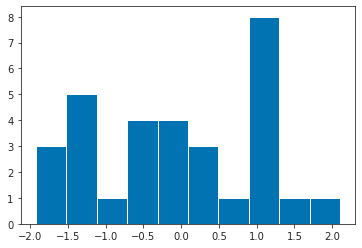

[array([[ 0.99781895, -1.2771012 ,  0.86099464,  0.91223973,  1.2469451 ,
        -1.1747154 , -1.4374957 ,  1.3784791 , -0.8408679 ,  1.1334777 ]],
      dtype=float32), array([-0.32966235, -0.46096858, -0.17440963, -0.23718259,  0.27485234,
        0.38621888, -0.53835386,  0.31251335, -0.24833122, -0.43525442],
      dtype=float32), array([[-1.6143097],
       [ 1.2864301],
       [-1.9344003],
       [-1.9189738],
       [ 1.1272511],
       [-1.1883587],
       [ 1.1604164],
       [ 1.0257328],
       [ 2.1128669],
       [-1.3064989]], dtype=float32), array([-0.1380355], dtype=float32)]


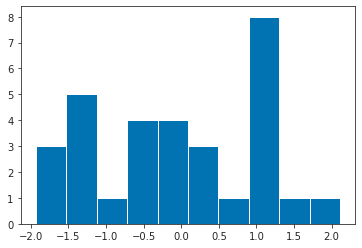

[array([[ 0.99552244, -1.2763397 ,  0.8620995 ,  0.91109896,  1.2457548 ,
        -1.1721828 , -1.4372581 ,  1.3770305 , -0.84150344,  1.131609  ]],
      dtype=float32), array([-0.32914686, -0.46075773, -0.16612622, -0.23447579,  0.26558843,
        0.39025047, -0.5371574 ,  0.30380535, -0.24516833, -0.43400002],
      dtype=float32), array([[-1.6088667],
       [ 1.2846032],
       [-1.9332278],
       [-1.9147816],
       [ 1.1235526],
       [-1.1876814],
       [ 1.1597024],
       [ 1.023248 ],
       [ 2.1119146],
       [-1.302486 ]], dtype=float32), array([-0.14165823], dtype=float32)]


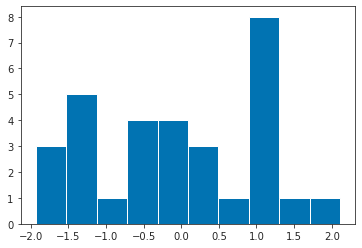

[array([[ 0.99440825, -1.2760383 ,  0.86124337,  0.9100314 ,  1.2461226 ,
        -1.1718769 , -1.4369761 ,  1.3774238 , -0.8408901 ,  1.1304222 ]],
      dtype=float32), array([-0.33012402, -0.4611349 , -0.16613625, -0.23520826,  0.2657419 ,
        0.39264303, -0.53748935,  0.30389667, -0.24627815, -0.4351551 ],
      dtype=float32), array([[-1.6076989],
       [ 1.284366 ],
       [-1.9321325],
       [-1.913861 ],
       [ 1.1239884],
       [-1.1884543],
       [ 1.1594697],
       [ 1.0236093],
       [ 2.1116014],
       [-1.3013275]], dtype=float32), array([-0.1427047], dtype=float32)]


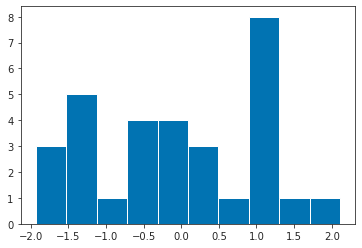

[array([[ 0.99412894, -1.275633  ,  0.86095446,  0.9097314 ,  1.2462339 ,
        -1.1721176 , -1.4365798 ,  1.377542  , -0.8404588 ,  1.1301366 ]],
      dtype=float32), array([-0.3301836 , -0.46152434, -0.16620174, -0.23532791,  0.26625127,
        0.39259085, -0.5378583 ,  0.30439696, -0.24672994, -0.43522155],
      dtype=float32), array([[-1.6075748],
       [ 1.2839481],
       [-1.9318169],
       [-1.9135497],
       [ 1.1242154],
       [-1.1886209],
       [ 1.1590505],
       [ 1.0238374],
       [ 2.1111827],
       [-1.3012811]], dtype=float32), array([-0.14280972], dtype=float32)]


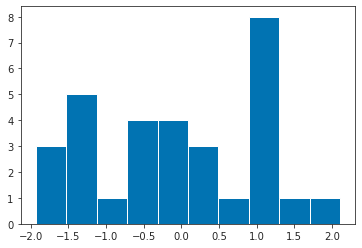

[array([[ 0.99469984, -1.2755741 ,  0.86177653,  0.9106299 ,  1.2469807 ,
        -1.1730274 , -1.4364483 ,  1.3782524 , -0.84068936,  1.130594  ]],
      dtype=float32), array([-0.33037508, -0.46205622, -0.16580614, -0.23460706,  0.26567057,
        0.39242232, -0.53855497,  0.30392188, -0.24652913, -0.4357201 ],
      dtype=float32), array([[-1.6083193],
       [ 1.2842587],
       [-1.9327172],
       [-1.9144495],
       [ 1.1246444],
       [-1.1892011],
       [ 1.1593868],
       [ 1.0242583],
       [ 2.1114306],
       [-1.3020732]], dtype=float32), array([-0.14229785], dtype=float32)]


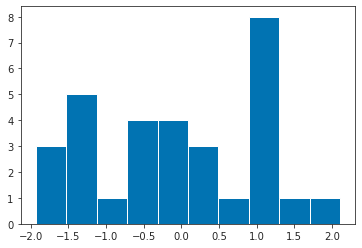

[array([[ 0.9947701, -1.2755233,  0.8619404,  0.9108095,  1.2472811,
        -1.1731851, -1.436387 ,  1.3785428, -0.8406574,  1.1306125]],
      dtype=float32), array([-0.33057275, -0.4621815 , -0.1657835 , -0.23452315,  0.26544362,
        0.392655  , -0.53870225,  0.30372995, -0.24658921, -0.4360269 ],
      dtype=float32), array([[-1.60859  ],
       [ 1.2842621],
       [-1.9329314],
       [-1.9146794],
       [ 1.1248491],
       [-1.189404 ],
       [ 1.1595724],
       [ 1.0244595],
       [ 2.1114113],
       [-1.3024172]], dtype=float32), array([-0.14198568], dtype=float32)]


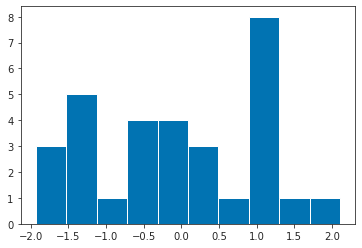

[array([[ 0.994738  , -1.2756313 ,  0.86190844,  0.9107692 ,  1.2472068 ,
        -1.1730015 , -1.4365008 ,  1.3784661 , -0.84075963,  1.130603  ]],
      dtype=float32), array([-0.33059937, -0.46194872, -0.16578986, -0.23455371,  0.26540068,
        0.3924185 , -0.53846276,  0.30369312, -0.24636361, -0.43601385],
      dtype=float32), array([[-1.6085185],
       [ 1.2842704],
       [-1.9328799],
       [-1.9146224],
       [ 1.1247629],
       [-1.1892424],
       [ 1.159396 ],
       [ 1.0243729],
       [ 2.1114562],
       [-1.3023261]], dtype=float32), array([-0.14196654], dtype=float32)]


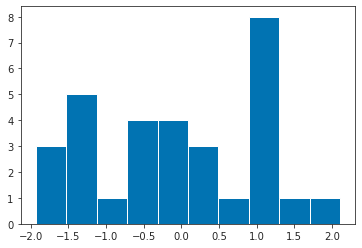

[array([[ 0.99480575, -1.2756066 ,  0.861902  ,  0.9107567 ,  1.2469094 ,
        -1.1730312 , -1.436482  ,  1.3781815 , -0.8407258 ,  1.1307073 ]],
      dtype=float32), array([-0.33039647, -0.46200684, -0.16578747, -0.23458768,  0.2656972 ,
        0.39249972, -0.5385098 ,  0.303949  , -0.24644178, -0.43572152],
      dtype=float32), array([[-1.6085331],
       [ 1.2842333],
       [-1.9328822],
       [-1.9146322],
       [ 1.1245524],
       [-1.1892489],
       [ 1.1593581],
       [ 1.0241657],
       [ 2.1114256],
       [-1.3023207]], dtype=float32), array([-0.14220132], dtype=float32)]


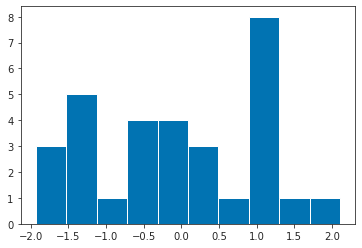

In [49]:
for qm in qmodels:
    plt.hist(np.concatenate([i.flatten() for i in qm.get_weights()]))
    print(qm.get_weights())
    plt.show()